# Text detection with OpenCV (EAST)

In computer vision, many tasks are devoted to object detection. We might interpret a text as an object in an image. The technique of detecting text in images is a paradigm in the computer vision community due to the enormous efforts in text detection. In real-world problems, images are not perfects and, most of the text detector fails in their tasks.

As highlighted by [PyImageSearch](https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/), when summarizing the paper [Natural Scene Text Understanding](https://www.researchgate.net/publication/221786127_Natural_Scene_Text_Understanding), the common issues are

- **Image/sensor noise**: Sensor noise from a handheld camera is typically higher than that of a traditional scanner. Additionally, low-priced cameras will typically interpolate the pixels of raw sensors to produce real colors.

- **Viewing angles**: Natural scene text can naturally have viewing angles that are not parallel to the text, making the text harder to recognize.

- **Blurring**: Uncontrolled environments tend to have blurred, especially if the end-user is utilizing a smartphone that does not have some form of stabilization.

- **Lighting conditions**: We cannot make any assumptions regarding our lighting conditions in natural scene images. It may be near dark, the flash on the camera may be on, or the sun may be shining brightly, saturating the entire image.

- **Resolution**: Not all cameras are created equal — we may be dealing with cameras with sub-par resolution.

- **Non-paper objects**: Most, but not all, paper is not reflective (at least in the context of paper you are trying to scan). Text in natural scenes may be reflective, including logos, signs, etc.

- **Non-planar objects**: Consider what happens when you wrap text around a bottle — the text on the surface becomes distorted and deformed. While humans may still be able to easily “detect” and read the text, our algorithms will struggle. We need to be able to handle such use cases.

- **Unknown layout**: We cannot use any a priori information to give our algorithms “clues” as to where the text resides.

In the work "[EAST: An Efficient and Accurate Scene Text Detector](https://arxiv.org/abs/1704.03155)", the authors propose a deep learning-based model for text detection. The idea behind the model is to directly predict words or text lines of arbitrary orientations and quadrilateral shapes in full images, eliminating unnecessary intermediate steps, with a single neural network.

The model architecture is represented in the following image.

![EAST model architecture!](image/EAST.png "EAST model")

The model consists of two stages: a Fully Convolutional Network (FCN) and an NMS (Nom Maximum Suppression). The FCN can be decomposed into two parts: feature extractor stem and feature-merging. The output layer can offer two different geometries, Rotated Box or Quadrangle. To obtain the final results, the geometries that survived after thresholding will be merged by NMS.

**Project Structure**

The project contains three folders. The first of them is the EAST module. This module determines which layers of the network we want to consider, in addition, it offers a pre-process function to convert the predictions into bounding box coordinates. The second folder contains the pre-trained model. The last folder is the dataset used in this example. The images are different scenarios and all of them contain text information.

## Importing Libraries


In [1]:
# East module
from east import EAST_OUTPUT_LAYERS
from east import decode_predictions
# Standart modules
from imutils import paths
import imutils
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Setting the dataset and the pre-trained model path

In [2]:
dataset = 'dataset' #folder path
paths = list(paths.list_images(dataset)) # list of image paths

In [3]:
model = 'model/frozen_east_text_detection.pb' # defining the model path

## Reading the test image

In [4]:
image = cv.imread(paths[1])

**Grabbing the original height and width**

In [5]:
(origH, origW) = image.shape[:2] #grabbing the image dimensions

**Defining the new image dimension and aspect ratio**

In [6]:
#defining the new Width and height, calculating the aspect ratio
(newW, newH) = (320, 320)
rW = origW / float(newW)
rH = origH / float(newH)

## Defining the model

In [7]:
net = cv.dnn.readNet(model)

**Preparing the image for predictions**

In [8]:
blob = cv.dnn.blobFromImage(image, 1.0, (newW, newH),
                            (123.68, 116.78, 103.94), 
                            swapRB=True, crop=False) #preparing the image for predictions

In [9]:
net.setInput(blob)# passing the transformed image

**making predictions**

Using the pre-trained model, we want to obtain the confidence score and the geometry informations to derive the text bounding boxes in the image.

In [10]:
(scores, geometry) = net.forward(EAST_OUTPUT_LAYERS)

**Post processing**

The model gives us the confidences and informations about the possible bounding boxes, but to obtain the exact bounding boxes, we must post-process these informations. To perform it, we call the function `decode_prediction` that returns the confidences and the bounding boxes coordinates. You find the details of the function in the file `east.py`.

In [11]:
(rects, confidence) = decode_predictions(scores, geometry)

**Selecting the bounding boxes**

In [12]:
#Non-maxima suppression to obtain on single box
idxs = cv.dnn.NMSBoxesRotated(rects, confidence, 0.5, 0.4)

In [13]:
if len(idxs) > 0:
    
    for i in idxs.flatten():
        
        box = cv.boxPoints(rects[i])
        box[:, 0] *= rW # rescaling the width
        box[:, 1] *= rH # rescaling the height
        box = np.int0(box) # putting all bounding boxes coordinates together
        
        cv.polylines(image, [box], True, (0, 255, 0), 2) # drawing the bounding box on the original image

**Visualizing the prediction**

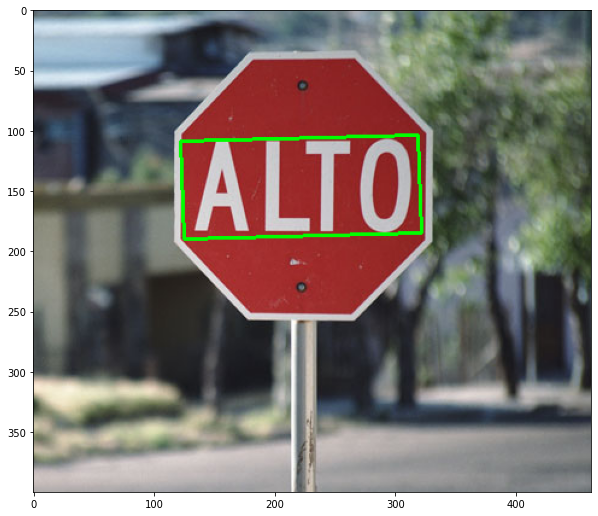

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()

## Detecting in multiples images

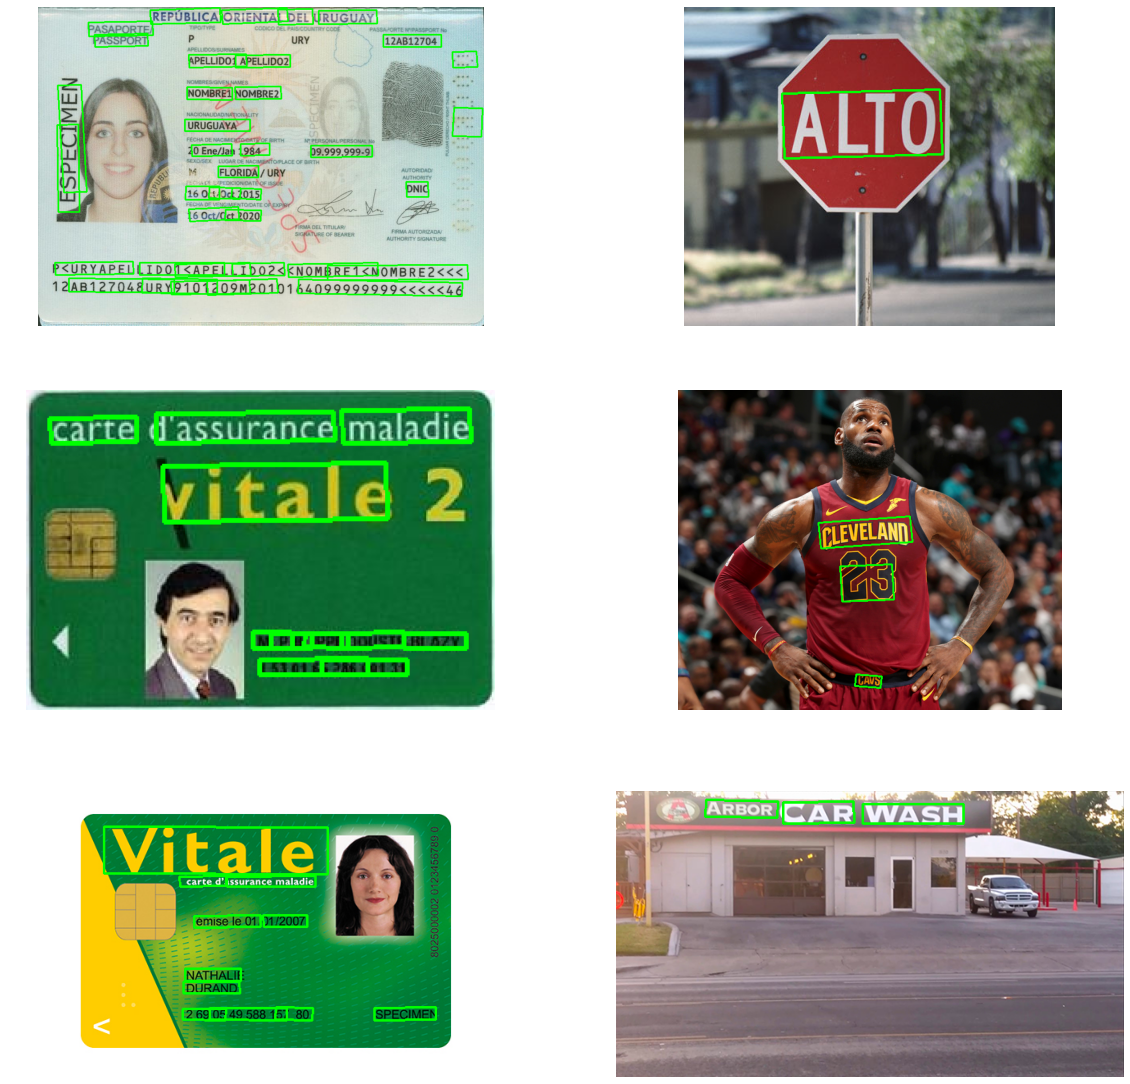

In [15]:
count = 1
plt.figure(figsize=(20,20))
for i in paths:
    img = cv.imread(i)
    (origH, origW) = img.shape[:2] #grabbing the image dimensions
    #defining the new Width and height, calculating the aspect ratio
    (newW, newH) = (320, 320)
    rW = origW / float(newW)
    rH = origH / float(newH)
    
    net = cv.dnn.readNet(model)
    
    blob = cv.dnn.blobFromImage(img, 1.0, (newW, newH),
                            (123.68, 116.78, 103.94), 
                            swapRB=True, crop=False) #preparing the image for predictions
    
    net.setInput(blob)# passing the transformed image
    
    (scores, geometry) = net.forward(EAST_OUTPUT_LAYERS)
    
    (rects, confidence) = decode_predictions(scores, geometry)
    
    #Non-maxima suppression to obtain on single box
    idxs = cv.dnn.NMSBoxesRotated(rects, confidence, 0.5, 0.4)
    
    if len(idxs) > 0:
    
        for i in idxs.flatten():

            box = cv.boxPoints(rects[i])
            box[:, 0] *= rW
            box[:, 1] *= rH
            box = np.int0(box)

            cv.polylines(img, [box], True, (0, 255, 0), 2)
    ax = plt.subplot(3,2,count)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    count += 1
plt.show()

## Conclusion

The EAST model is an efficient method to detect text in images. The results are near to be perfect, but as with all models, there are some limitations. For example, in the passport, the text with a small size was not detected, beyond it, there's a false positive case and some numbers without detection. Another remark is the number 23 on the t-shirt of the basketball player, the bounding box was shrunken, this is a characteristic of the model. In the image of the French Health Card, the number of series is positioned in the vertical and not detected.